## 0. Imports

In [82]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt

import missingno as msno

from xgboost import XGBClassifier

from category_encoders import TargetEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.manifold import TSNE

from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import SVMSMOTE, SMOTE, ADASYN

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

from bayes_opt import BayesianOptimization

warnings.filterwarnings("ignore")

## 1. Loading the data

In [2]:
# Load the dataset
df = pd.read_csv('data.csv')

## 2. Checking the properties and structure

### 2.1. Checking overall structure

In [3]:
df.columns

Index(['KEY', 'VAR_TARGET', 'VAR_1', 'VAR_2', 'VAR_3', 'VAR_4', 'VAR_5',
       'VAR_6', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_10', 'VAR_11', 'VAR_12',
       'VAR_13', 'VAR_14', 'VAR_15', 'VAR_16', 'VAR_17', 'VAR_18', 'VAR_19',
       'VAR_20', 'VAR_21', 'VAR_22', 'VAR_23', 'VAR_24', 'VAR_25', 'VAR_26',
       'VAR_27', 'VAR_28', 'VAR_29', 'VAR_30', 'VAR_31', 'VAR_32', 'VAR_33',
       'VAR_34', 'VAR_35', 'VAR_36', 'VAR_37', 'VAR_38', 'VAR_39', 'VAR_40',
       'VAR_41', 'VAR_42', 'VAR_43', 'VAR_44', 'VAR_45', 'VAR_46', 'VAR_47',
       'VAR_48', 'VAR_49', 'VAR_50'],
      dtype='object')

In [4]:
# Display the first 5 rows of the dataset
df.head()

,KEY,VAR_TARGET,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,VAR_8,...,VAR_41,VAR_42,VAR_43,VAR_44,VAR_45,VAR_46,VAR_47,VAR_48,VAR_49,VAR_50
0,1,0,6603,W,34.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,1300,NaN
1,2,1,5210,I,34.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,1570,1800.0
2,3,1,2505,Q,7.0,NaN,NaN,0.0,1000.0,915.0,...,269.0,1004.0,NaN,1000.0,1000.0,1560.0,553.0,1567.0,1450,1450.0
3,4,1,3902,Q,34.0,NaN,NaN,0.0,1000.0,722.0,...,30.0,16.0,NaN,1000.0,1000.0,1301.0,17.0,1301.0,2000,2000.0
4,5,1,4607,Q,34.0,11187.0,11187.0,1.0,27187.0,5436.0,...,74.0,38.0,NaN,13594.0,16000.0,1518.0,19.0,1389.0,1700,1700.0


In [5]:
# Display the summary of the dataframe including the column names, non-null count and dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5626 entries, 0 to 5625
Data columns (total 52 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   KEY         5626 non-null   int64  
 1   VAR_TARGET  5626 non-null   int64  
 2   VAR_1       5626 non-null   int64  
 3   VAR_2       5626 non-null   object 
 4   VAR_3       5622 non-null   float64
 5   VAR_4       4344 non-null   float64
 6   VAR_5       4344 non-null   float64
 7   VAR_6       5612 non-null   float64
 8   VAR_7       5612 non-null   float64
 9   VAR_8       5612 non-null   float64
 10  VAR_9       5612 non-null   float64
 11  VAR_10      5612 non-null   float64
 12  VAR_11      5316 non-null   float64
 13  VAR_12      5626 non-null   int64  
 14  VAR_13      4528 non-null   float64
 15  VAR_14      4528 non-null   float64
 16  VAR_15      1801 non-null   float64
 17  VAR_16      5598 non-null   object 
 18  VAR_17      5508 non-null   float64
 19  VAR_18      5612 non-null  

In [6]:
# Display statistical summary of the dataframe
df.describe()

,KEY,VAR_TARGET,VAR_1,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,VAR_8,VAR_9,...,VAR_41,VAR_42,VAR_43,VAR_44,VAR_45,VAR_46,VAR_47,VAR_48,VAR_49,VAR_50
count,5626.000000,5626.000000,5626.000000,5622.000000,4344.000000,4344.000000,5612.000000,5612.000000,5612.000000,5612.000000,...,5621.000000,5621.000000,34.000000,5612.000000,4528.000000,1814.000000,5621.000000,2306.000000,5.626000e+03,3362.000000
mean,2813.500000,0.043726,3257.151973,33.639808,6513.402164,3401.622238,0.617962,9748.699572,4144.263899,1148.589095,...,2195.338730,2199.308842,3611.764706,4129.482359,2299.436617,2401.598126,2149.124177,1897.083261,6.115745e+03,3508.943783
std,1624.230638,0.204502,888.997086,5.607477,7635.750969,4629.699543,1.368544,16482.921883,8517.336280,2160.342345,...,15104.976409,15096.942980,2696.766561,4737.091335,3525.160200,2180.234920,15469.080255,1818.558706,8.491456e+04,6886.322041
min,1.000000,0.000000,1800.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1300.000000,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000e+00,500.000000
25%,1407.250000,0.000000,2606.000000,34.000000,2000.000000,800.000000,0.000000,2000.000000,616.500000,160.000000,...,0.000000,0.000000,2084.500000,1201.500000,0.000000,1364.000000,0.000000,893.000000,1.650000e+03,1774.750000
50%,2813.500000,0.000000,3103.000000,34.000000,4050.000000,1800.000000,0.000000,5000.000000,2051.000000,582.000000,...,2.000000,12.000000,2985.000000,2650.000000,1000.000000,1855.500000,18.000000,1541.500000,2.500000e+03,2500.000000
75%,4219.750000,0.000000,3707.000000,34.000000,7900.000000,4200.000000,1.000000,11062.500000,4715.750000,1331.000000,...,238.000000,304.000000,3800.000000,5200.000000,3000.000000,2909.000000,328.000000,2449.000000,3.500000e+03,3600.000000
max,5626.000000,1.000000,7011.000000,81.000000,81500.000000,45000.000000,31.000000,304800.000000,178711.000000,50203.000000,...,529716.000000,543328.000000,15000.000000,43700.000000,50000.000000,55594.000000,561609.000000,29422.000000,4.200000e+06,220000.000000


### 2.2. Checking Missing Data 

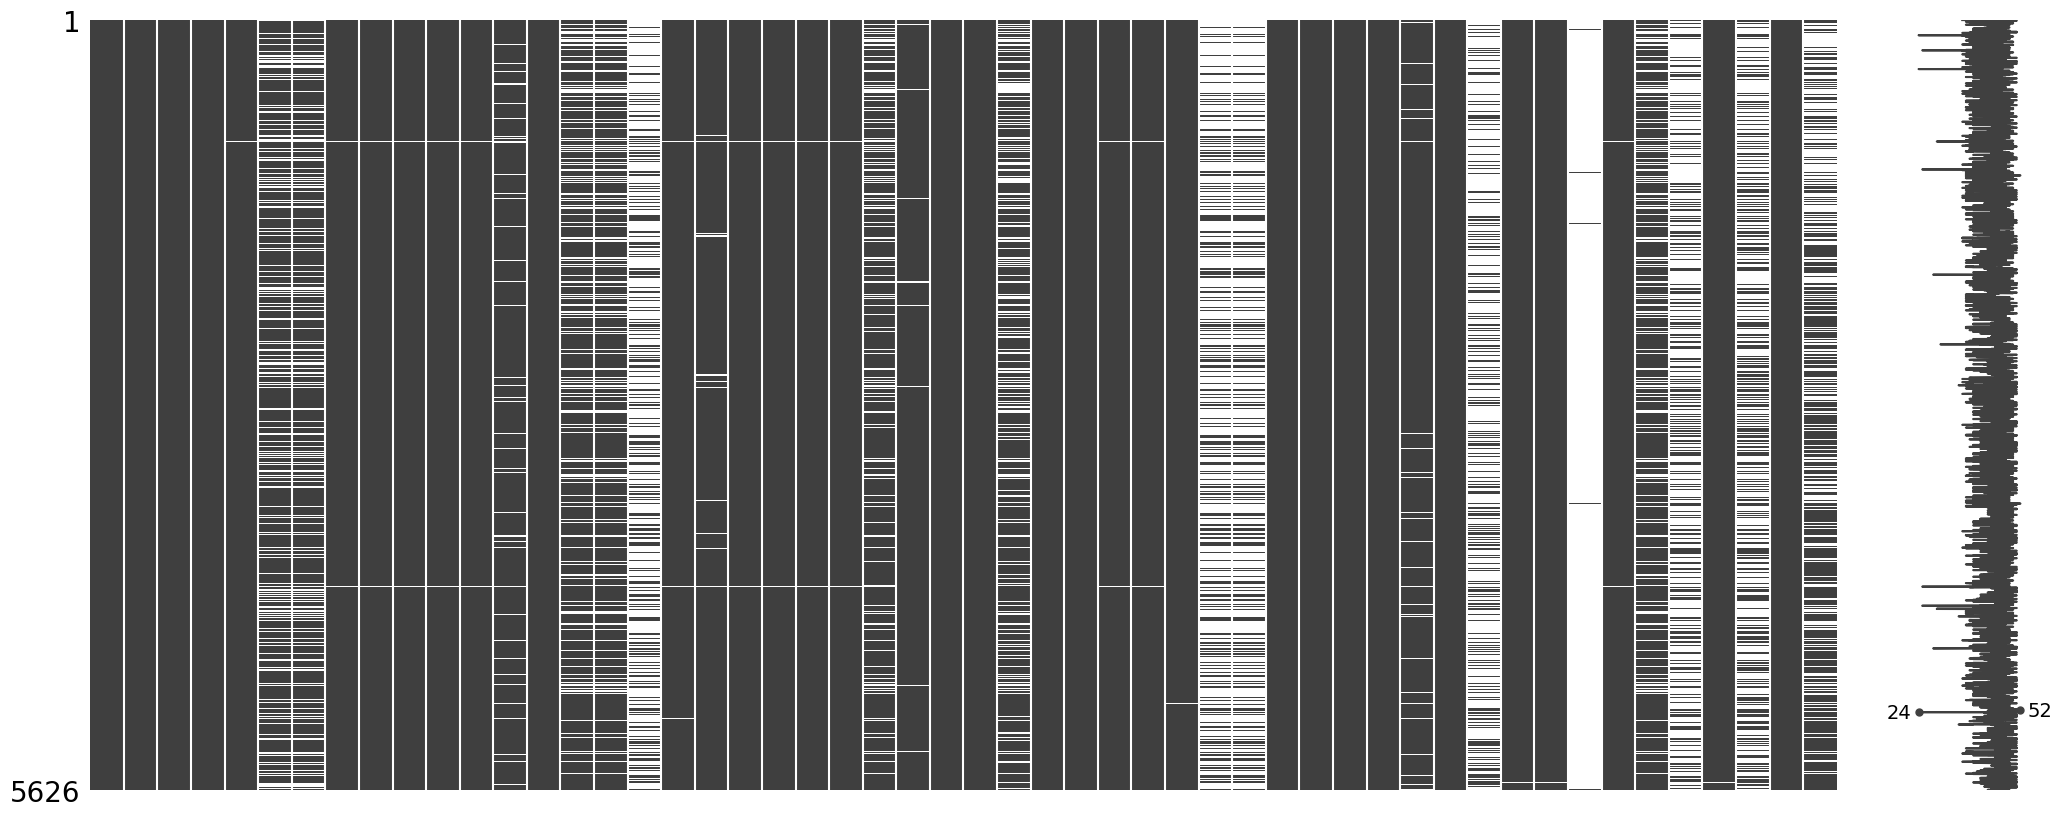

In [7]:
# Visualize missing values as a matrix
_ = msno.matrix(df)

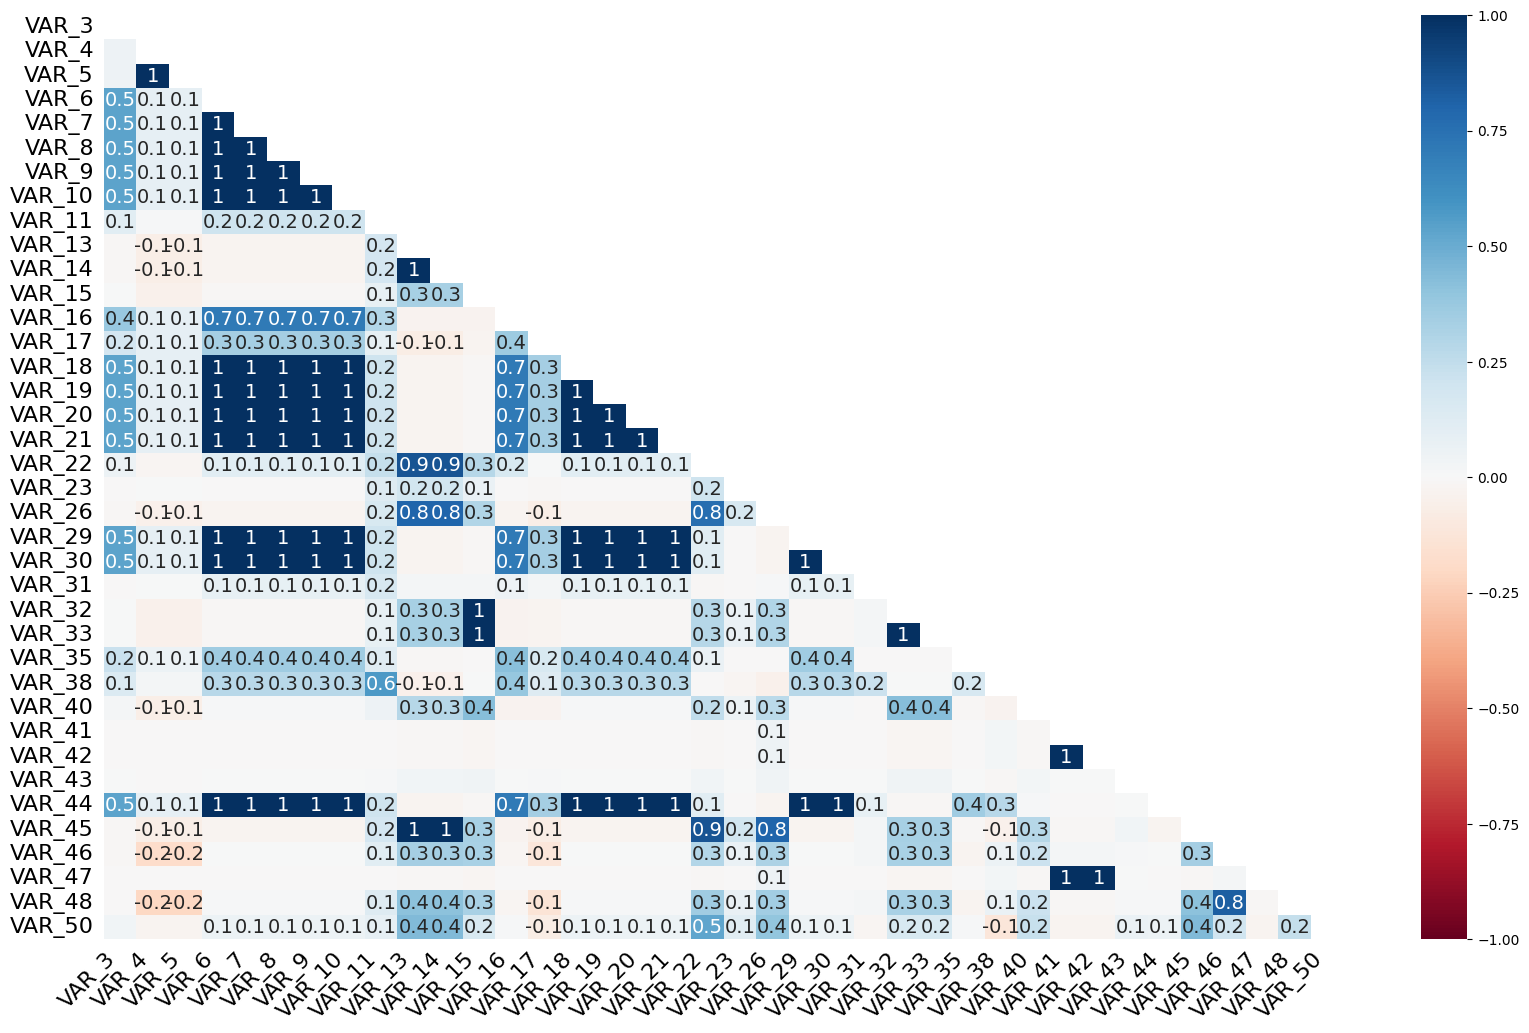

In [8]:
# Visualize the correlation of missingness between different features
_ = msno.heatmap(df)


In [9]:
#df.isna().sum()
df.isna().sum()[df.isna().sum() > 2813]   #More than 50% missing

VAR_15    3825
VAR_32    3825
VAR_33    3825
VAR_40    4113
VAR_43    5592
VAR_46    3812
VAR_48    3320
dtype: int64

In [10]:
df.columns

Index(['KEY', 'VAR_TARGET', 'VAR_1', 'VAR_2', 'VAR_3', 'VAR_4', 'VAR_5',
       'VAR_6', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_10', 'VAR_11', 'VAR_12',
       'VAR_13', 'VAR_14', 'VAR_15', 'VAR_16', 'VAR_17', 'VAR_18', 'VAR_19',
       'VAR_20', 'VAR_21', 'VAR_22', 'VAR_23', 'VAR_24', 'VAR_25', 'VAR_26',
       'VAR_27', 'VAR_28', 'VAR_29', 'VAR_30', 'VAR_31', 'VAR_32', 'VAR_33',
       'VAR_34', 'VAR_35', 'VAR_36', 'VAR_37', 'VAR_38', 'VAR_39', 'VAR_40',
       'VAR_41', 'VAR_42', 'VAR_43', 'VAR_44', 'VAR_45', 'VAR_46', 'VAR_47',
       'VAR_48', 'VAR_49', 'VAR_50'],
      dtype='object')

### 2.3. Fraud vs Non Fraud Percentage

In [11]:
print('No Frauds', round(df['VAR_TARGET'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['VAR_TARGET'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 95.63 % of the dataset
Frauds 4.37 % of the dataset


## 3. Train Test Split

In [12]:
# Separate the target variable and input variables
X = df.drop(columns = ['VAR_TARGET', 'KEY'], axis=1)
y = df['VAR_TARGET']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 4. Baseline Model
Before I proceed with data cleaning, such as filling missing values, dropping columns etc. I want to create a baseline model first

In [13]:
# Define the target encoder
encoder = TargetEncoder()

# Fit and transform the training data
X_train_encoded = encoder.fit_transform(X_train, y_train)

# Transform the test data
X_test_encoded = encoder.transform(X_test)


In [14]:
# Create a base XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fit the model
model.fit(X_train_encoded, y_train)

# Make predictions
y_pred = model.predict(X_test_encoded)

# Calculate recall for each class
recall = recall_score(y_test, y_pred, average=None)
recall_0 = recall[0]
recall_1 = recall[1]

# Check the conditions
condition_1 = recall_0 / recall_1 <= 0.025
condition_2 = (recall_0 + recall_1) / 2 >= 0.75

print(f"Recall for class 0: {recall_0}")
print(f"Recall for class 1: {recall_1}")
print(f"Condition 1 is {'met' if condition_1 else 'not met'}, {recall_0 / recall_1} <= 0.025")
print(f"Condition 2 is {'met' if condition_2 else 'not met'}, {(recall_0 + recall_1) / 2} >= 0.75")

Recall for class 0: 0.9971883786316776
Recall for class 1: 0.0847457627118644
Condition 1 is not met, 11.766822867853797 <= 0.025
Condition 2 is not met, 0.5409670706717711 >= 0.75


- Recall of 0.997 for class 0 means that your model correctly identified about 99.7% of non-fraudulent transactions.
- Recall of 0.085 for class 1 means that your model correctly identified about 8.5% of fraudulent transactions.
- Model is much better at identifying non-fraudulent transactions than fraudulent transactions. (Which is suboptimal)
- Model's overall ability to identify both fraudulent and non-fraudulent transactions is not very high. (Which is suboptimal)

## 5. Preprocessing


### 5.1. Testing Functions
To test the changes I make during the preprocessing I created functions

In [79]:
# I created a function to test the preprocessing steps I do
def evaluate_preprocessing(X_train, y_train, X_test, y_test):
    # Create a base XGBoost model
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate recall for each class
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)

    # Calculate F1 score for each class
    f1_0 = f1_score(y_test, y_pred, pos_label=0)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)

    # Print the metrics
    print("Recall for class 0: %f" % recall_0, "Recall for class 1: %f" % recall_1)
    print("F1 score for class 0: %f" % f1_0, "F1 score for class 1: %f" % f1_1)

    # Check the conditions
    condition_1 = recall_0 / recall_1 <= 0.025
    condition_2 = (recall_0 + recall_1) / 2 >= 0.75

    print(f"Condition 1 is {'met' if condition_1 else 'not met'}, {recall_0 / recall_1} <= 0.025")
    print(f"Condition 2 is {'met' if condition_2 else 'not met'}, {(recall_0 + recall_1) / 2} >= 0.75")

In [16]:
def split_and_encode(df):

    # Separate the target variable and input variables
    X = df.drop(columns = ['VAR_TARGET', 'KEY'], axis=1)
    y = df['VAR_TARGET']

    # Split the data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Define the target encoder
    encoder = TargetEncoder()

    # Fit and transform the training data
    X_train_encoded = encoder.fit_transform(X_train, y_train)

    # Transform the test data
    X_test_encoded = encoder.transform(X_test)

    return X_train_encoded, X_test_encoded, y_train, y_test

In [17]:
def test_changes(df, split_func, eval_func):
    X_train_encoded, X_test_encoded, y_train, y_test = split_func(df)
    eval_func(X_train_encoded, y_train, X_test_encoded, y_test)
    return X_train_encoded, X_test_encoded, y_train, y_test

### 5.2. Filling Nulls

In [29]:
# Calculate the percentage of missing values in each column
missing_percent = df.isnull().sum() / len(df)

# Get a list of columns with more than 40% missing values
cols_to_drop = missing_percent[missing_percent > 0.5].index

# Drop these columns
df_dropped = df.drop(cols_to_drop, axis=1)

_,_,_,_ = test_changes(df_dropped, split_and_encode, evaluate_preprocessing)

Recall for class 0: 0.996286
Recall for class 1: 0.102041
Condition 1 is not met, 9.763602599814298 <= 0.025
Condition 2 is not met, 0.5491633979497091 >= 0.75


We can see that all metrics improved after this so we are keeping this.

In [19]:
df_dropped.describe()

,KEY,VAR_TARGET,VAR_1,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,VAR_8,VAR_9,...,VAR_35,VAR_38,VAR_39,VAR_41,VAR_42,VAR_44,VAR_45,VAR_47,VAR_49,VAR_50
count,5626.000000,5626.000000,5626.000000,5622.000000,4344.000000,4344.000000,5612.000000,5612.000000,5612.000000,5612.000000,...,5621.000000,5447.000000,5626.000000,5621.000000,5621.000000,5612.000000,4528.000000,5621.000000,5.626000e+03,3362.000000
mean,2813.500000,0.043726,3257.151973,33.639808,6513.402164,3401.622238,0.617962,9748.699572,4144.263899,1148.589095,...,2.272194,470.449605,6.789193,2195.338730,2199.308842,4129.482359,2299.436617,2149.124177,6.115745e+03,3508.943783
std,1624.230638,0.204502,888.997086,5.607477,7635.750969,4629.699543,1.368544,16482.921883,8517.336280,2160.342345,...,1.490632,442.597967,15.260115,15104.976409,15096.942980,4737.091335,3525.160200,15469.080255,8.491456e+04,6886.322041
min,1.000000,0.000000,1800.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,500.000000
25%,1407.250000,0.000000,2606.000000,34.000000,2000.000000,800.000000,0.000000,2000.000000,616.500000,160.000000,...,1.000000,105.000000,0.000000,0.000000,0.000000,1201.500000,0.000000,0.000000,1.650000e+03,1774.750000
50%,2813.500000,0.000000,3103.000000,34.000000,4050.000000,1800.000000,0.000000,5000.000000,2051.000000,582.000000,...,2.000000,402.000000,0.000000,2.000000,12.000000,2650.000000,1000.000000,18.000000,2.500000e+03,2500.000000
75%,4219.750000,0.000000,3707.000000,34.000000,7900.000000,4200.000000,1.000000,11062.500000,4715.750000,1331.000000,...,3.000000,708.000000,7.000000,238.000000,304.000000,5200.000000,3000.000000,328.000000,3.500000e+03,3600.000000
max,5626.000000,1.000000,7011.000000,81.000000,81500.000000,45000.000000,31.000000,304800.000000,178711.000000,50203.000000,...,5.000000,4311.000000,184.000000,529716.000000,543328.000000,43700.000000,50000.000000,561609.000000,4.200000e+06,220000.000000


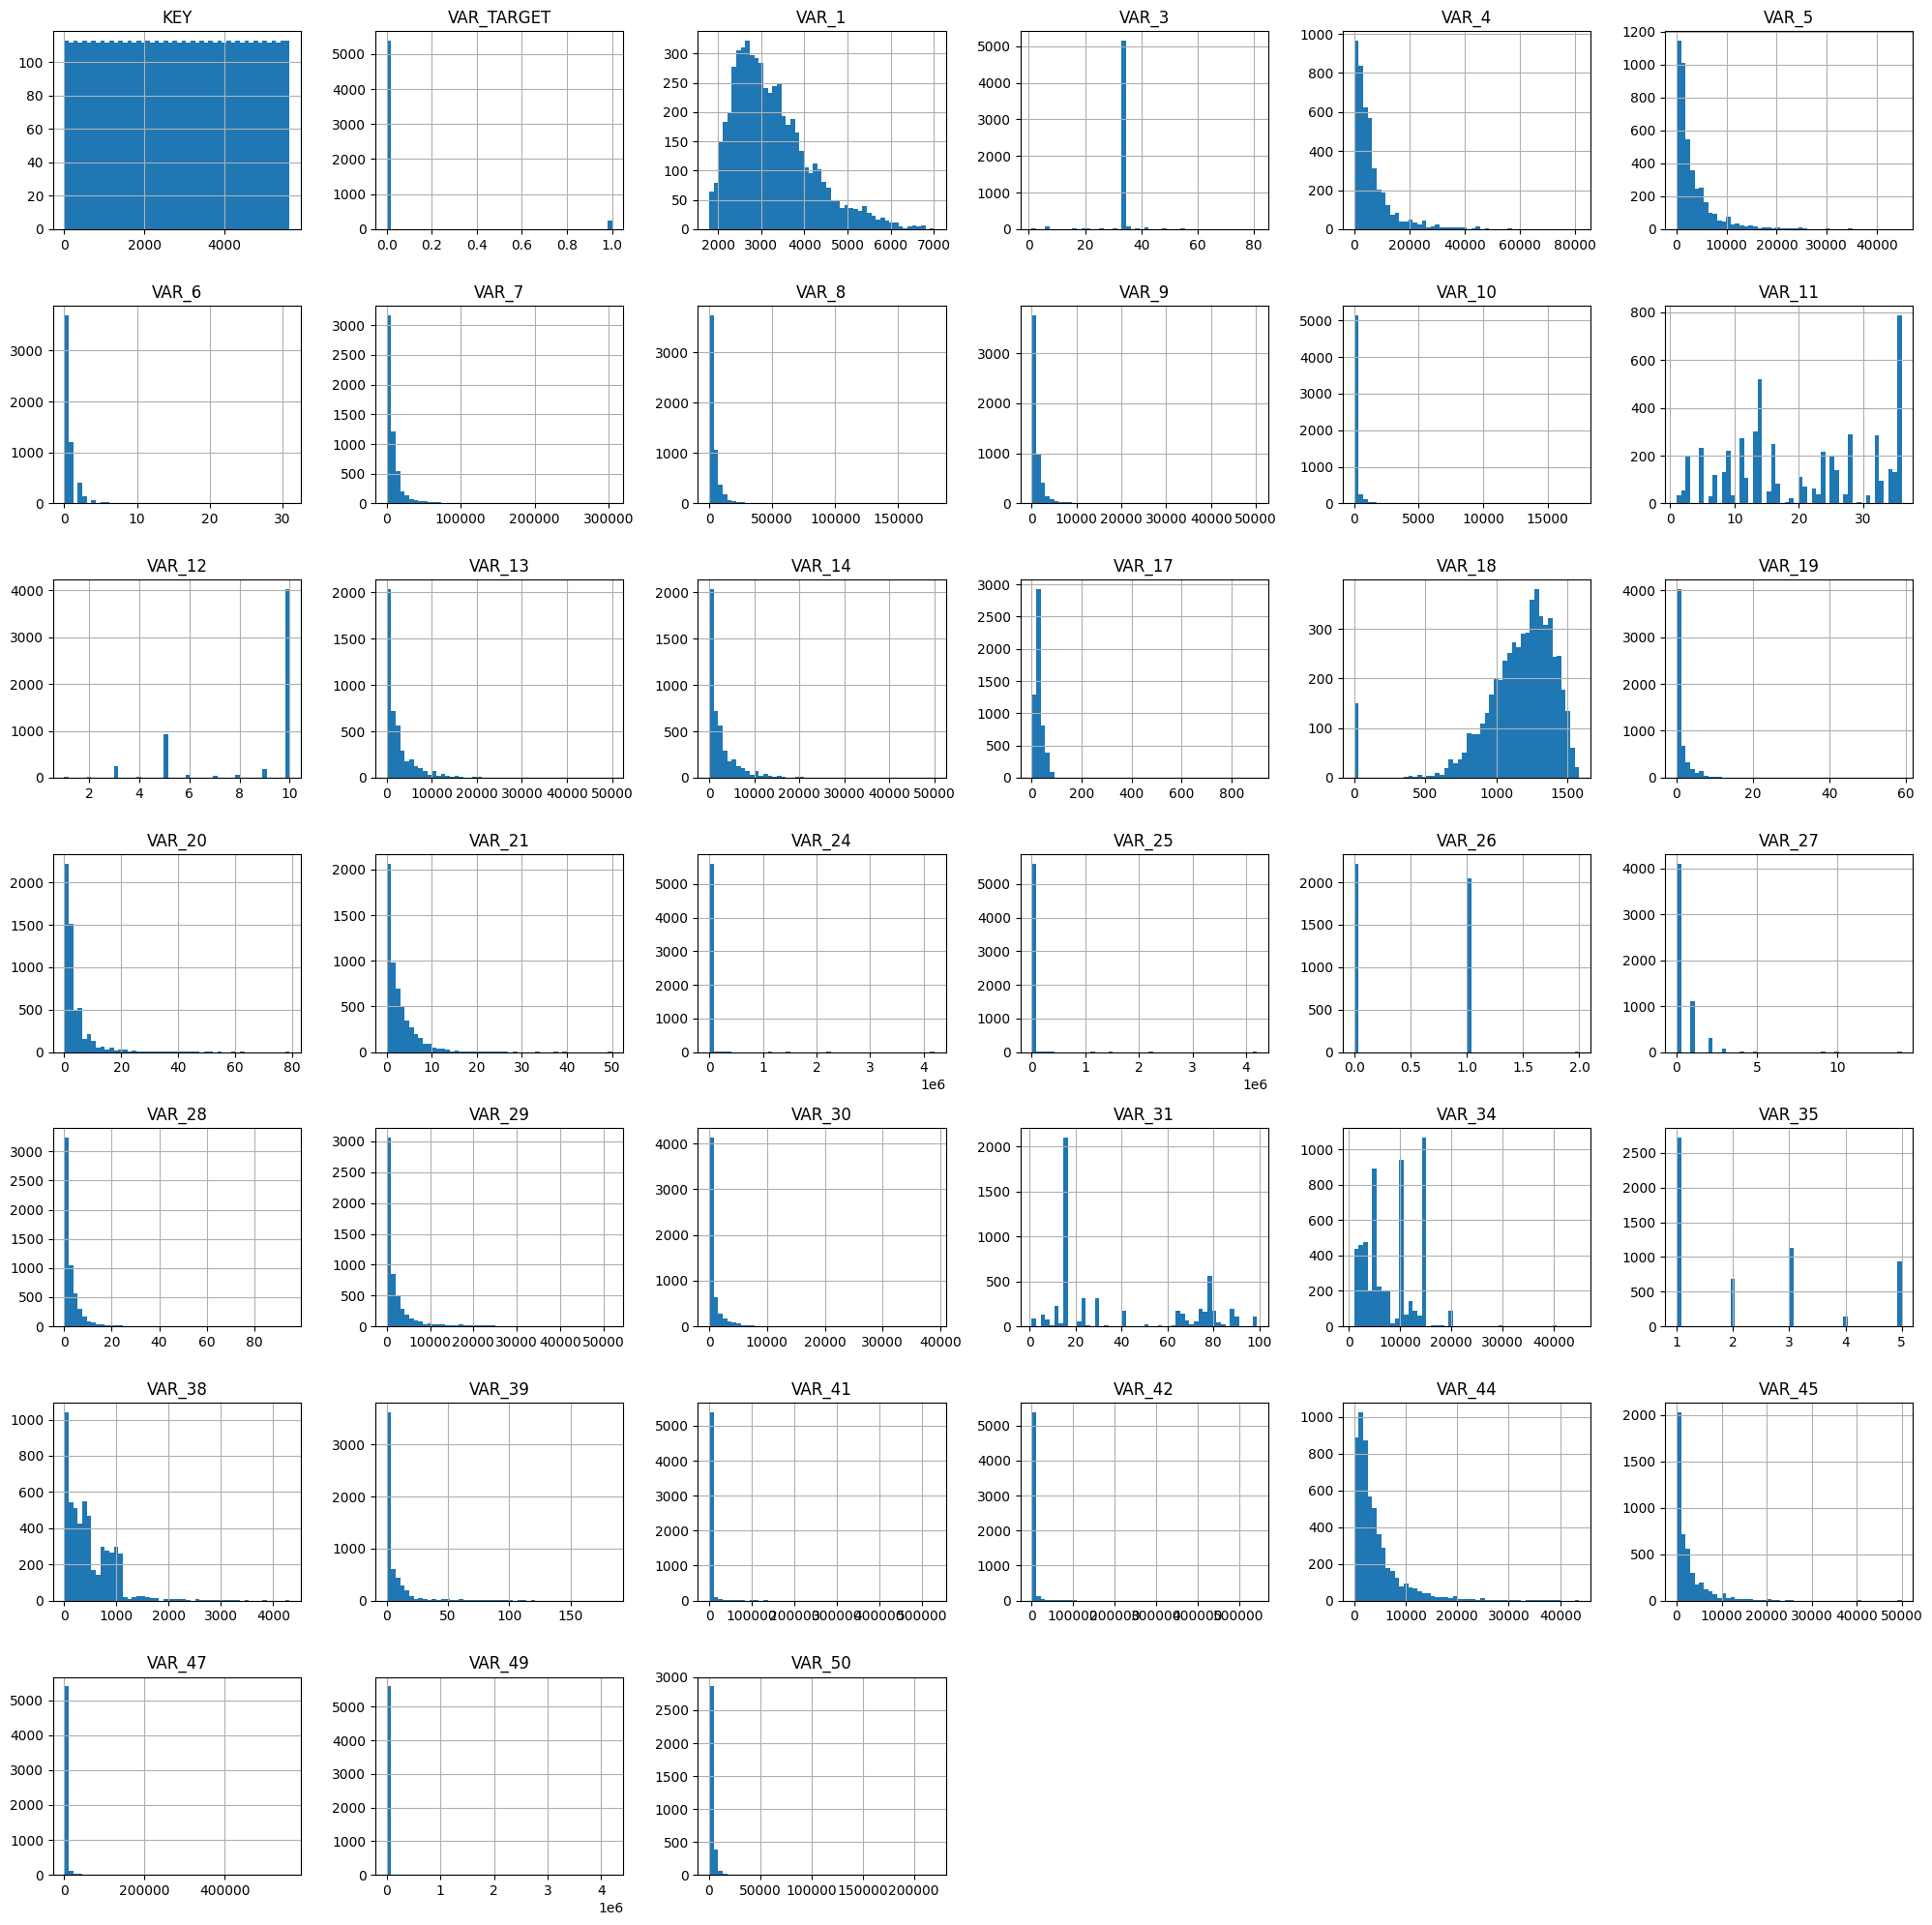

In [20]:
df_dropped.hist(figsize=(20, 20), bins=50)
plt.tight_layout()  # adjusts subplot params so that the subplots fit in the figure area.
plt.show()

In [30]:
# Let's try to fill the numerical columns with median values

def split_encode_impute_numerical(df):
    # Separate the target variable and input variables
    X = df.drop(columns = ['VAR_TARGET', 'KEY'], axis=1)
    y = df['VAR_TARGET']

    # Split the data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Define the imputers
    num_imputer = SimpleImputer(strategy='median')  # for numerical columns

    # List of numerical columns
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

    # Impute missing values in numerical columns
    X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
    X_test[num_cols] = num_imputer.transform(X_test[num_cols])

    # Define the target encoder
    encoder = TargetEncoder()

    # Fit and transform the training data
    X_train_encoded = encoder.fit_transform(X_train, y_train)

    # Transform the test data
    X_test_encoded = encoder.transform(X_test)

    return X_train_encoded, X_test_encoded, y_train, y_test

def split_encode_impute_cat(df):
    # Separate the target variable and input variables
    X = df.drop(columns = ['VAR_TARGET', 'KEY'], axis=1)
    y = df['VAR_TARGET']

    # Split the data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Define the imputers
    cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')  # for categorical columns

    # List of categorical columns
    cat_cols = X_train.select_dtypes(include=['object']).columns

    # Impute missing values in categorical columns
    X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
    X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])


    # Define the target encoder
    encoder = TargetEncoder()

    # Fit and transform the training data
    X_train_encoded = encoder.fit_transform(X_train, y_train)

    # Transform the test data
    X_test_encoded = encoder.transform(X_test)

    return X_train_encoded, X_test_encoded, y_train, y_test

def split_encode_impute(df):
    # Separate the target variable and input variables
    X = df.drop(columns = ['VAR_TARGET', 'KEY'], axis=1)
    y = df['VAR_TARGET']

    # Split the data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Define the imputers
    num_imputer = SimpleImputer(strategy='median')  # for numerical columns
    cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')  # for categorical columns

    # List of numerical columns
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

    # List of categorical columns
    cat_cols = X_train.select_dtypes(include=['object']).columns

    # Impute missing values in numerical columns
    X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
    X_test[num_cols] = num_imputer.transform(X_test[num_cols])

    # Impute missing values in categorical columns
    X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
    X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])

    # Define the target encoder
    encoder = TargetEncoder()

    # Fit and transform the training data
    X_train_encoded = encoder.fit_transform(X_train, y_train)

    # Transform the test data
    X_test_encoded = encoder.transform(X_test)

    return X_train_encoded, X_test_encoded, y_train, y_test

def split_encode_impute_knn(df):
    # Separate the target variable and input variables
    X = df.drop(columns = ['VAR_TARGET', 'KEY'], axis=1)
    y = df['VAR_TARGET']

    # Split the data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Define the imputers
    num_imputer = KNNImputer(n_neighbors=5)  # for numerical columns
    cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')  # for categorical columns

    # List of numerical columns
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

    # List of categorical columns
    cat_cols = X_train.select_dtypes(include=['object']).columns

    # Impute missing values in numerical columns
    X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
    X_test[num_cols] = num_imputer.transform(X_test[num_cols])

    # Impute missing values in categorical columns
    X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
    X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])

    # Define the target encoder
    encoder = TargetEncoder()

    # Fit and transform the training data
    X_train_encoded = encoder.fit_transform(X_train, y_train)

    # Transform the test data
    X_test_encoded = encoder.transform(X_test)

    return X_train_encoded, X_test_encoded, y_train, y_test

- Only imputing categoricals with 'missing' doesn't change any metric
- Only imputing numericals with median lowers Recall for 1 by 0.01
- Imputing both gives the same result as only imputing numericals
- Using KNN for imputing generated worse results. <br>
P.S On a final note I will only impute the categorical values.

### 5.3. Testing Impute Methods

In [22]:
# Default
print('Without Impute')
_,_,_,_ = test_changes(df_dropped, split_and_encode, evaluate_preprocessing)
print('-'*50)
# Imputing numerical with median
print('Imputing numerical with median')
_,_,_,_ = test_changes(df_dropped, split_encode_impute_numerical, evaluate_preprocessing)
print('-'*50)
# Imputing categorical with 'missing'
print('Imputing categorical with missing')
_,_,_,_ = test_changes(df_dropped, split_encode_impute_cat, evaluate_preprocessing)
print('-'*50)
# Imputing categorical and numerical
print('Imputing categorical and numerical')
X_train_full, X_test_full, y_train_full, y_test_full = test_changes(df_dropped, split_encode_impute, evaluate_preprocessing)
print('-'*50)
#Imputing with knn
print('Imputing with knn')
_,_,_,_ = test_changes(df_dropped, split_encode_impute_knn, evaluate_preprocessing)

Without Impute
Recall for class 0: 0.996286
Recall for class 1: 0.102041
Condition 1 is not met, 9.763602599814298 <= 0.025
Condition 2 is not met, 0.5491633979497091 >= 0.75
--------------------------------------------------
Imputing numerical with median
Recall for class 0: 0.997214
Recall for class 1: 0.061224
Condition 1 is not met, 16.287836583101207 <= 0.025
Condition 2 is not met, 0.5292194872377921 >= 0.75
--------------------------------------------------
Imputing categorical with missing
Recall for class 0: 0.996286
Recall for class 1: 0.102041
Condition 1 is not met, 9.763602599814298 <= 0.025
Condition 2 is not met, 0.5491633979497091 >= 0.75
--------------------------------------------------
Imputing categorical and numerical
Recall for class 0: 0.997214
Recall for class 1: 0.061224
Condition 1 is not met, 16.287836583101207 <= 0.025
Condition 2 is not met, 0.5292194872377921 >= 0.75
--------------------------------------------------
Imputing with knn
Recall for class 0: 0

### 5.4. Using t-SNE before Undersampling

In [27]:
def plot_tsne(X, y, perplexity=30):
    # Define t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)

    # Drop missing values
    X_no_na = X.dropna()

    # Get the corresponding y values
    y_no_na = y[X_no_na.index]

    # Apply t-SNE to the data
    X_tsne = tsne.fit_transform(X_no_na)

    # Create a scatter plot
    plt.figure(figsize=(12, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_no_na, cmap='viridis', alpha = 0.7)

    # Add labels and a title
    plt.xlabel('t-SNE feature 0')
    plt.ylabel('t-SNE feature 1')
    plt.title('t-SNE visualization of the data')
    plt.show()

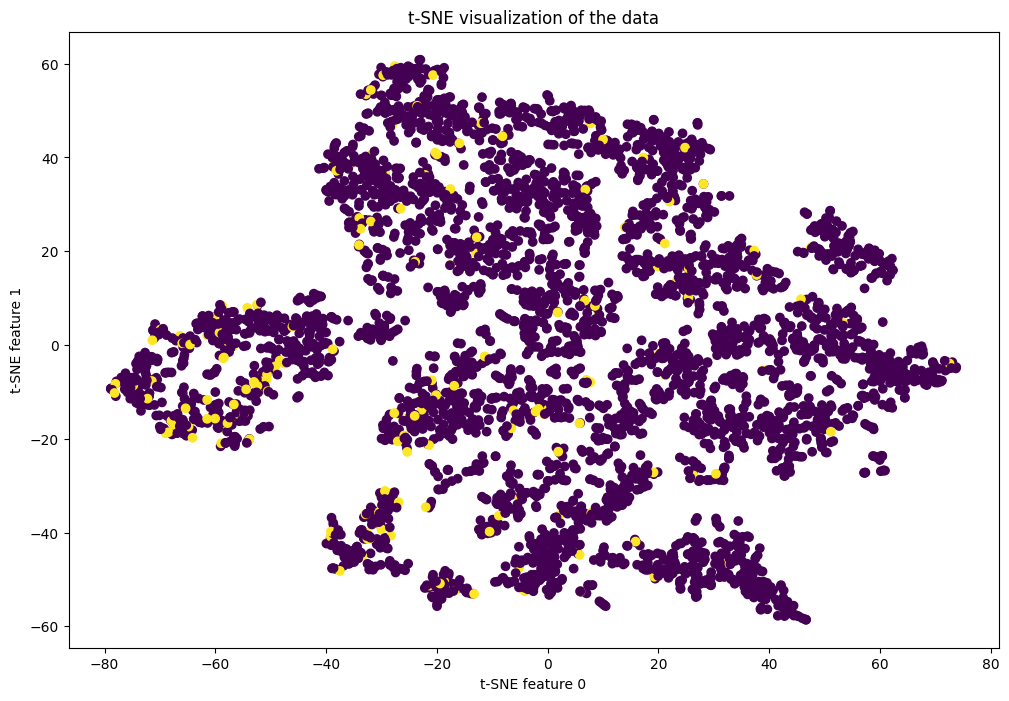

In [26]:
plot_tsne(X_train_full, y_train_full)

### 5.5. Undersampling

#### 5.5.1. Random Undersampler

In [47]:
# Define the undersampler
undersampler = RandomUnderSampler(sampling_strategy='majority')

# Fit the undersampler and sample the data
X_train_undersampled_random, y_train_undersampled_random = undersampler.fit_resample(X_train_full, y_train)

In [48]:
y_train_undersampled_random.sum()/len(y_train_undersampled_random)

0.5

#### 5.5.2. NearMiss

In [62]:
# Version 1
near_miss1 = NearMiss(version=1)
X_train_undersampled_nm1, y_train_undersampled_nm1 = near_miss1.fit_resample(X_train_full, y_train)
# Version 2
near_miss2 = NearMiss(version=2)
X_train_undersampled_nm2, y_train_undersampled_nm2 = near_miss2.fit_resample(X_train_full, y_train)
# Version 3
near_miss3 = NearMiss(version=3)
X_train_undersampled_nm3, y_train_undersampled_nm3 = near_miss3.fit_resample(X_train_full, y_train)

In [63]:
print(y_train_undersampled_nm1.sum()/len(y_train_undersampled_nm1))
print(y_train_undersampled_nm2.sum()/len(y_train_undersampled_nm2))
print(y_train_undersampled_nm3.sum()/len(y_train_undersampled_nm3))

0.5
0.5
0.5


### 5.6. tSNE after Undersampling

#### 5.6.1 Random Undersampler

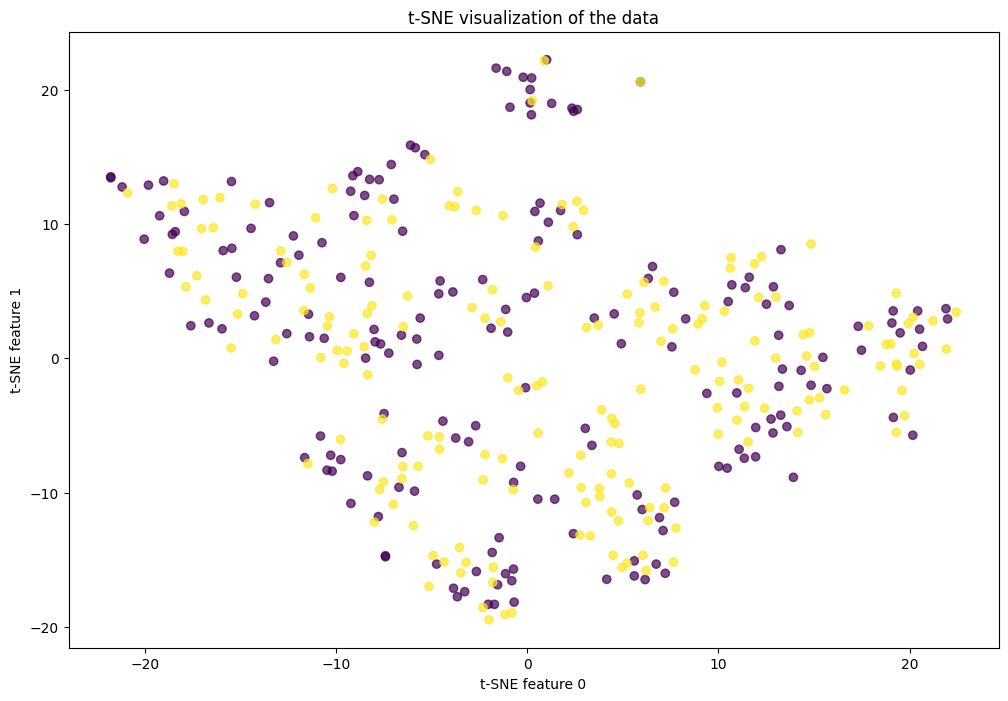

In [35]:
plot_tsne(X_train_undersampled_random, y_train_undersampled_random)

#### 5.6.2. NearMiss

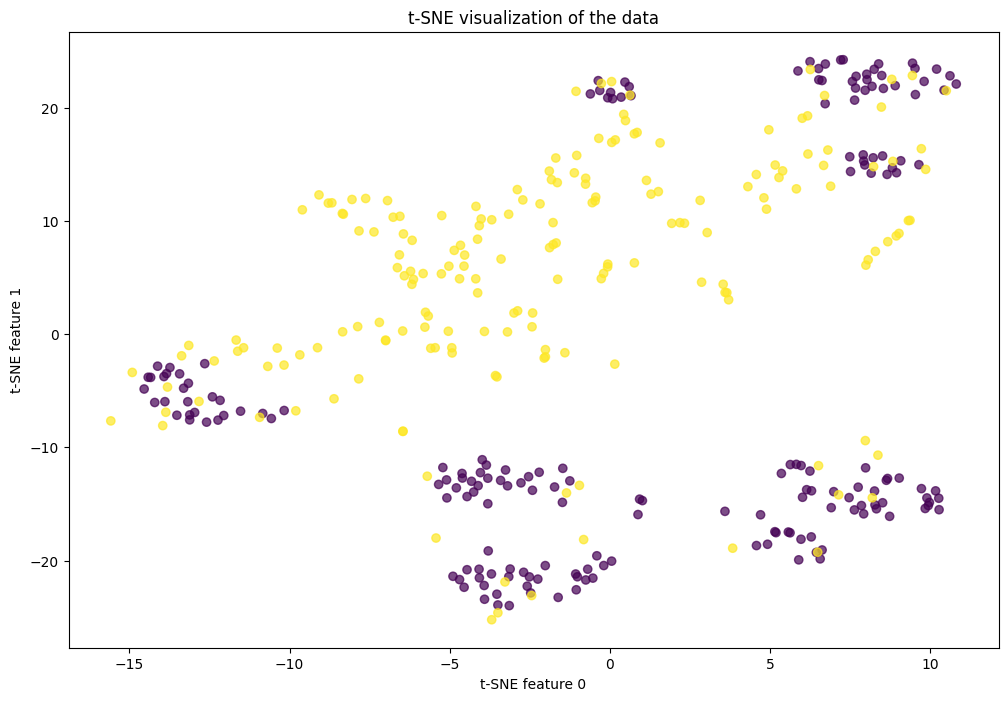

In [64]:
plot_tsne(X_train_undersampled_nm1, y_train_undersampled_nm1)

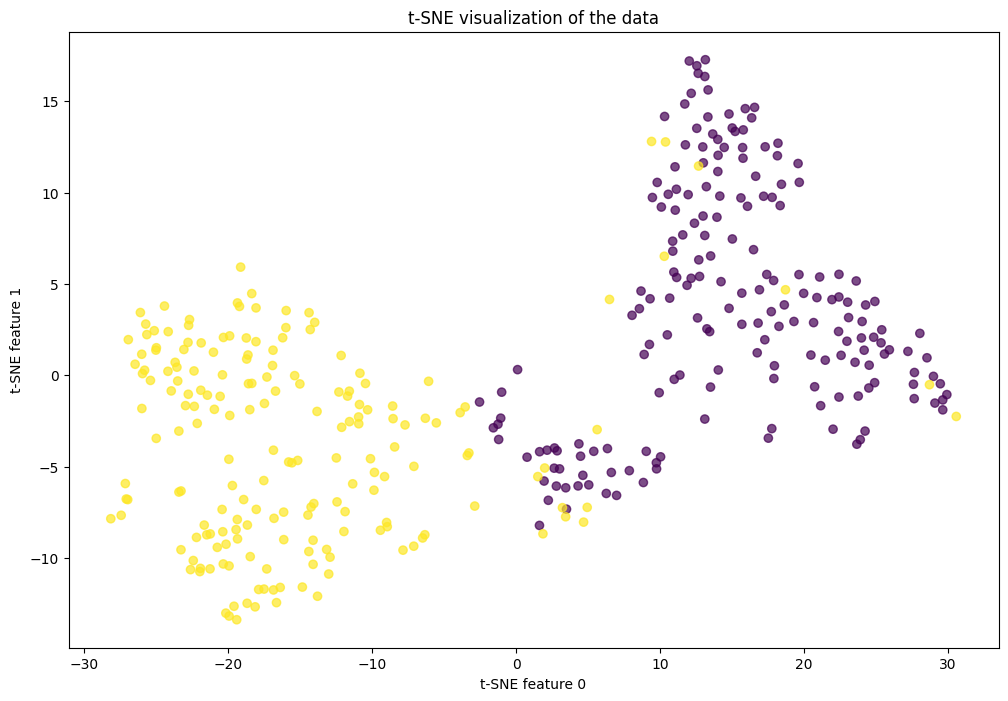

In [65]:
plot_tsne(X_train_undersampled_nm2, y_train_undersampled_nm2)

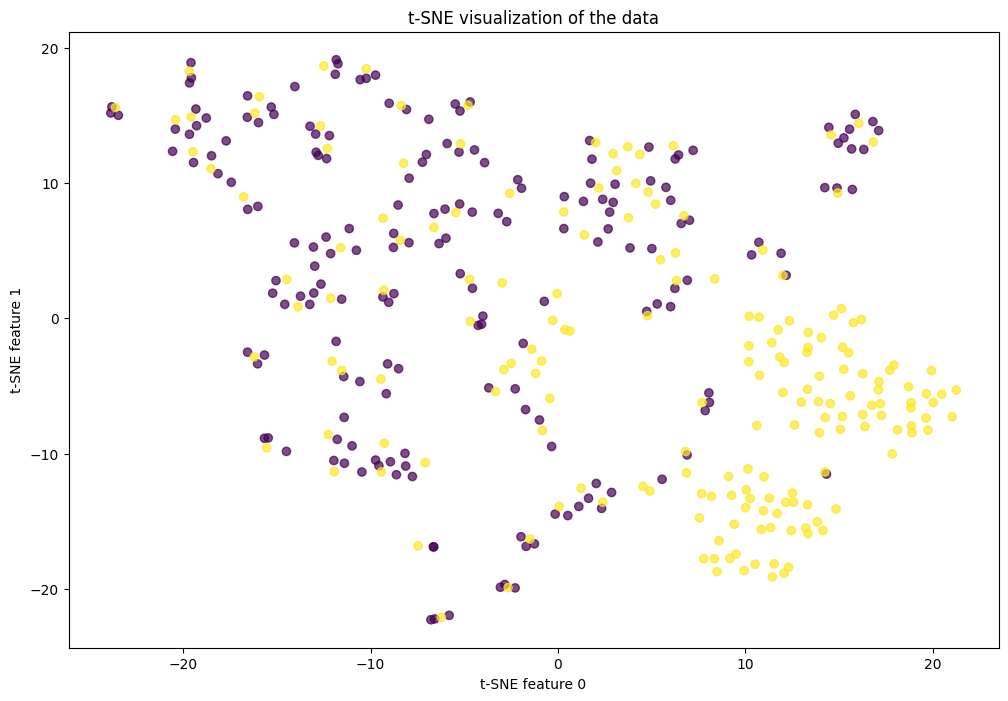

In [66]:
plot_tsne(X_train_undersampled_nm3, y_train_undersampled_nm3)

### 5.7. Oversampling

#### 5.7.1 SMOTE

In [37]:
# Create SMOTE object
smote = SMOTE(random_state=42)

# Resample the data
X_train_oversampled_smote, y_train_oversampled_smote = smote.fit_resample(X_train_full, y_train)

In [44]:
y_train_oversampled_smote.sum()/len(y_train_oversampled_smote)

0.5

#### 5.7.2 SVMSMOTE

In [67]:
svmsmote = SVMSMOTE()
X_train_oversampled_svmsmote, y_train_oversampled_svmsmote = svmsmote.fit_resample(X_train_full, y_train)

In [69]:
y_train_oversampled_svmsmote.sum()/len(y_train_oversampled_svmsmote)

0.3611316841949341

#### 5.7.3 ADASYN

In [38]:
# Create ADASYN object
adasyn = ADASYN(random_state=42)

# Resample the data
X_train_oversampled_adasyn, y_train_oversampled_adasyn = adasyn.fit_resample(X_train_full, y_train)

In [43]:
y_train_oversampled_adasyn.sum()/len(y_train_oversampled_adasyn)

0.5000579575750551

### 5.8. tSNE after Oversampling

#### 5.8.1 SMOTE

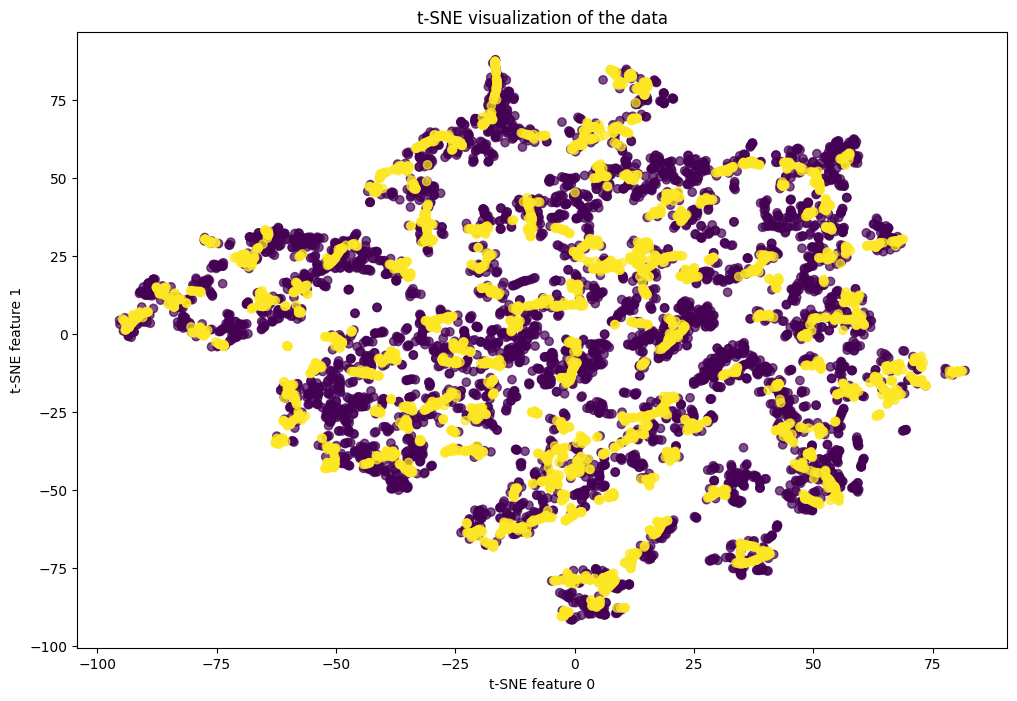

In [39]:
#SMOTE
plot_tsne(X_train_oversampled_smote, y_train_oversampled_smote)

#### 5.8.2 SVMSMOTE

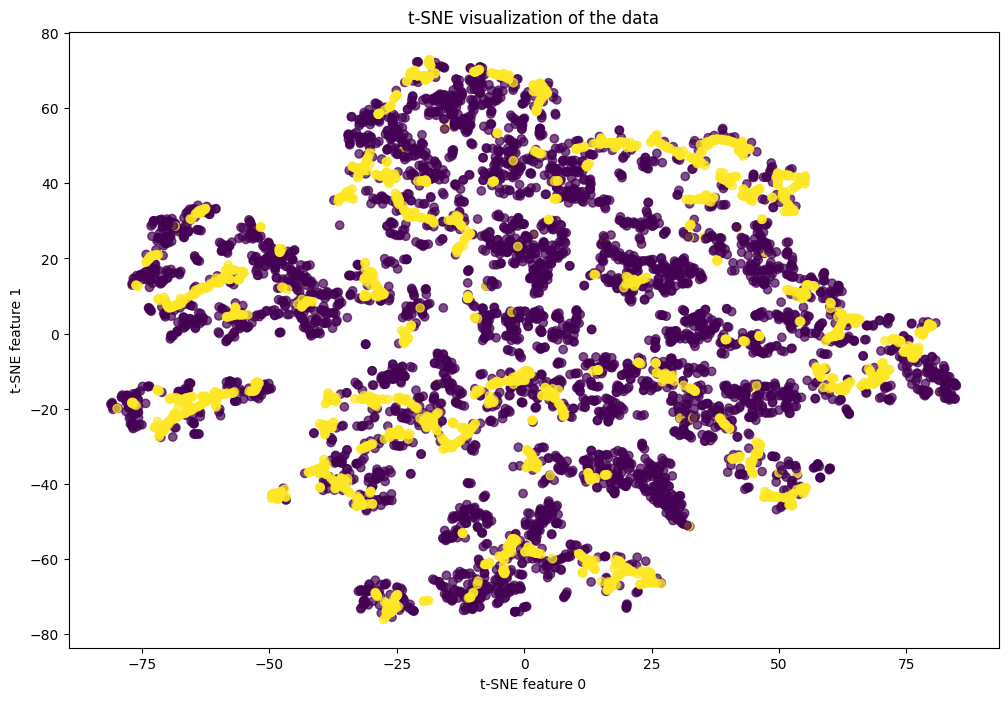

In [70]:
plot_tsne(X_train_oversampled_svmsmote, y_train_oversampled_svmsmote)

#### 5.8.3 ADASYN

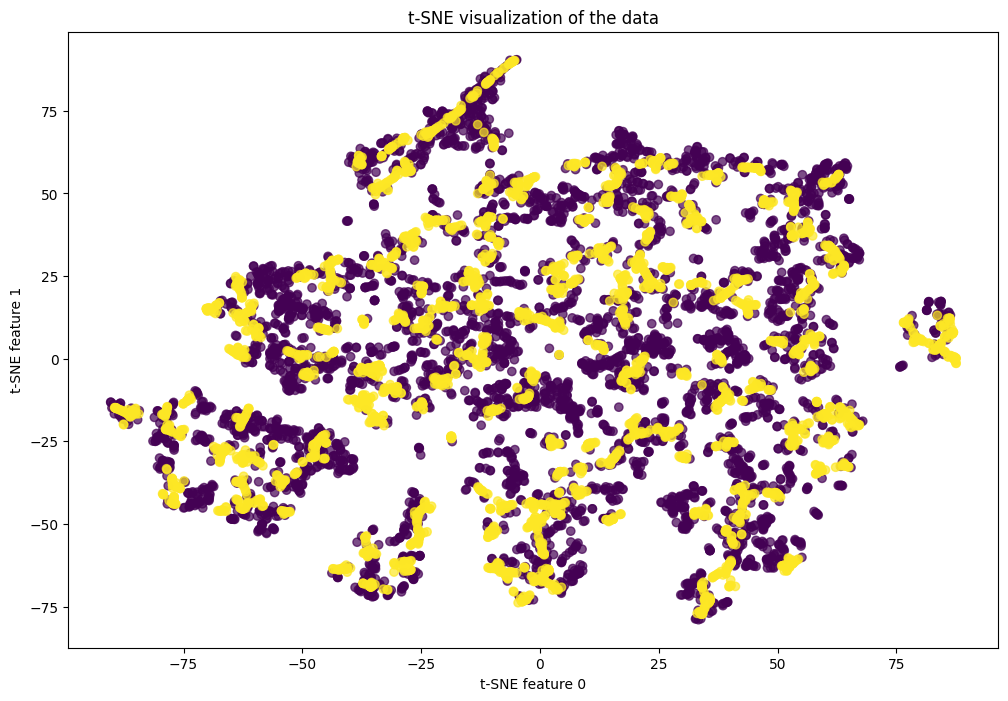

In [40]:
#ADASYN
plot_tsne(X_train_oversampled_adasyn, y_train_oversampled_adasyn)

### 5.9. Testing Oversampling and Undersampling

#### 5.9.1 Testing Undersampling Methods

In [80]:
# Random Undersampler
print('Random Undersampler')
print(evaluate_preprocessing(X_train_undersampled_random, y_train_undersampled_random, X_test_full, y_test))
print('-'*50)
# NearMiss1 Undersampler
print('NearMiss1 Undersampler')
print(evaluate_preprocessing(X_train_undersampled_nm1, y_train_undersampled_nm1, X_test_full, y_test))
print('-'*50)
# NearMiss2 Undersampler
print('NearMiss2 Undersampler')
print(evaluate_preprocessing(X_train_undersampled_nm2, y_train_undersampled_nm2, X_test_full, y_test))
print('-'*50)
# NearMiss1 Undersampler
print('NearMiss3 Undersampler')
print(evaluate_preprocessing(X_train_undersampled_nm3, y_train_undersampled_nm3, X_test_full, y_test))

Random Undersampler
Recall for class 0: 0.519213 Recall for class 1: 0.508475
F1 score for class 0: 0.671515 F1 score for class 1: 0.099668
Condition 1 is not met, 1.021118400499844 <= 0.025
Condition 2 is not met, 0.513843661144028 >= 0.75
None
--------------------------------------------------
NearMiss1 Undersampler
Recall for class 0: 0.159325 Recall for class 1: 0.881356
F1 score for class 0: 0.273312 F1 score for class 1: 0.103175
Condition 1 is not met, 0.18077283541201067 <= 0.025
Condition 2 is not met, 0.5203405715374962 >= 0.75
None
--------------------------------------------------
NearMiss2 Undersampler
Recall for class 0: 0.082474 Recall for class 1: 0.949153
F1 score for class 0: 0.151986 F1 score for class 1: 0.102377
Condition 1 is not met, 0.08689248895434462 <= 0.025
Condition 2 is not met, 0.5158133845885026 >= 0.75
None
--------------------------------------------------
NearMiss3 Undersampler
Recall for class 0: 0.385192 Recall for class 1: 0.694915
F1 score for cla

#### 5.9.2 Testing Oversampling Methods

In [74]:
# SMOTE Oversampler
print('SMOTE Oversampler')
print(evaluate_preprocessing(X_train_oversampled_smote, y_train_oversampled_smote, X_test_full, y_test))
print('-'*50)
# SVMSMOTE Oversampler
print('SVMSMOTE Oversampler')
print(evaluate_preprocessing(X_train_oversampled_svmsmote, y_train_oversampled_svmsmote, X_test_full, y_test))
print('-'*50)
# ADASYN Oversampler
print('ADASYN Oversampler')
print(evaluate_preprocessing(X_train_oversampled_adasyn, y_train_oversampled_adasyn, X_test_full, y_test))

SMOTE Oversampler
Recall for class 0: 1.000000
Recall for class 1: 0.000000
Condition 1 is not met, inf <= 0.025
Condition 2 is not met, 0.5 >= 0.75
None
--------------------------------------------------
SVMSMOTE Oversampler
Recall for class 0: 0.998126
Recall for class 1: 0.000000
Condition 1 is not met, inf <= 0.025
Condition 2 is not met, 0.4990627928772259 >= 0.75
None
--------------------------------------------------
ADASYN Oversampler
Recall for class 0: 1.000000
Recall for class 1: 0.000000
Condition 1 is not met, inf <= 0.025
Condition 2 is not met, 0.5 >= 0.75
None


## 6. Creating the model

### 6.1. Hyperparameter Optimization using Optuna

In [ ]:
def optimize_xgb(X_train, X_test, y_train, y_test, n_trials = 100):
    def objective(trial: Trial) -> float:
        params{}